In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

library(survival)
library(survminer)
library(survcomp)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:d

#### Settings 

In [2]:
base_theme <- theme_classic(base_size = 25) 
theme <- (
    base_theme + 
    theme(plot.margin = unit(c(0,0,0,0), "cm"),
          legend.position="none")
)
remove <- theme(axis.title.y=element_blank(), axis.text.y=element_blank())
remove_x <- theme(axis.title.x=element_blank())

### 0 - read in validation data

In [3]:
validation_measure <-
readRDS(paste0(TMP_DIR, "validation-measure.Rds")) %>% 
  select(
    patient_id, 
    build, 
    Study_cohort, 
    model, 
    tissue, 
    complete, 
    bor, 
    os_event, 
    os_days,
    os, 
    pred_lr, 
    pred_os ) %>% 
filter(!is.na(bor), !is.na(os_event), complete, !grepl("HMF", Study_cohort), model == "five_latent")

In [4]:
validation_measure$lr_gp <-  factor(cut( validation_measure$pred_lr,  breaks = c(0,.1,.5,    1) , labels = c("Low", "Medium", "High")), levels = c("Low", "Medium", "High"))
validation_measure$os_gp <-  factor(cut( validation_measure$pred_os,  breaks = c(0,.5,1.5,   20) , labels = c("Low", "Medium", "High")), levels = c("Low", "Medium", "High"))

### 1 - Fit coxph models 

In [5]:
validation_measure <- validation_measure %>% mutate( Study_cohort = ifelse(Study_cohort == 'External Studies', "Validation Cohorts", Study_cohort))

In [6]:
studies <- unique(validation_measure$Study_cohort)

In [7]:
fits_lr <- list()
fits_os <- list()
for( i in studies){
    fits_lr[[i]] <- survfit(Surv(os_days/(365/12), os_event) ~ lr_gp, data = validation_measure %>% filter(Study_cohort == i))
}
for( i in studies){
    fits_os[[i]] <- survfit(Surv(os_days/(365/12), os_event) ~ os_gp, data = validation_measure %>% filter(Study_cohort == i))
}

### 2 - Make plots

In [8]:
ggsurvplot_facet2 <- function(pval.size = 5, ...)
{
  newcall <- bquote(
    p <- p + geom_text(data = pvals.df, aes(x = pval.x, y = pval.y, label = pval.txt), size = .(pval.size), hjust = 0)
    )

    body(ggsurvplot_facet)[[20]][[3]][[8]] <- newcall
    ggsurvplot_facet(...)
}
cols <- brewer.pal(6,"RdYlGn")[c(6,1,3)]

In [9]:
go_surv <- function(pts, i, cols) {
  ggsurvplot_facet2(
    pts[[i]], 
    validation_measure %>% filter(Study_cohort == i), 
    ggtheme = theme, 
    xlab = "Months", 
    ylab = "Survival Probability",
    facet.by = "Study_cohort", 
    pval = TRUE, 
    palette = cols,
    short.panel.labs=T,
    pval.coord = c(20,.94), 
    pval.size = 4)
}

In [23]:
options(repr.plot.width=4, repr.plot.height=4)
clean <- theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.text = element_text(size = 12), legend.position="none")
no_legend <- theme(legend.position="none")

#### Response Strata

In [24]:
plts_lr <- list()
plts_os <- list()
for( i in studies){
    if( i %in% c("RAVI", "VHIO")){
        plts_lr[[i]] <- go_surv(fits_lr, i, cols = cols[-1])
    } else {
        plts_lr[[i]] <- go_surv(fits_lr, i, cols = cols)
    }
    plts_os[[i]] <- go_surv(fits_os, i, cols = cols[c(2,1,3)]) #+ scale_x_continuous(breaks = c(0,10,20,50), limits = c(0,55))
}

### Combine Plots

In [25]:
cleaner <- (
    theme(plot.title = element_text(size = 30), 
          axis.title = element_text(size = 20), 
          axis.text = element_text(size = 20),
          plot.margin = unit(c(.3,.3,.3,.3), "cm"))
)

In [26]:
lr <- as_ggplot(arrangeGrob( plts_lr$'Validation Cohorts' + no_legend, 
                  plts_lr$VHIO + clean, 
                  plts_lr$RAVI  + clean, 
                  plts_lr$INSPIRE  + clean, 
                  layout_matrix = rbind(c(1,1,2,3,4)))) + cleaner + ggtitle("Response Group Stata")

In [27]:
os <- as_ggplot((arrangeGrob( plts_os$'Validation Cohorts' + no_legend, 
                  plts_os$VHIO + clean, 
                  plts_os$RAVI  + clean, 
                  plts_os$INSPIRE  + clean, 
                  layout_matrix = rbind(c(1,1,2,3,4))))) + cleaner + ggtitle("Survival Group Stata")

In [28]:
options(repr.plot.width=11, repr.plot.height=10, resolution = 500)
share <- as_ggplot((arrangeGrob(lr, os, ncol = 1)))

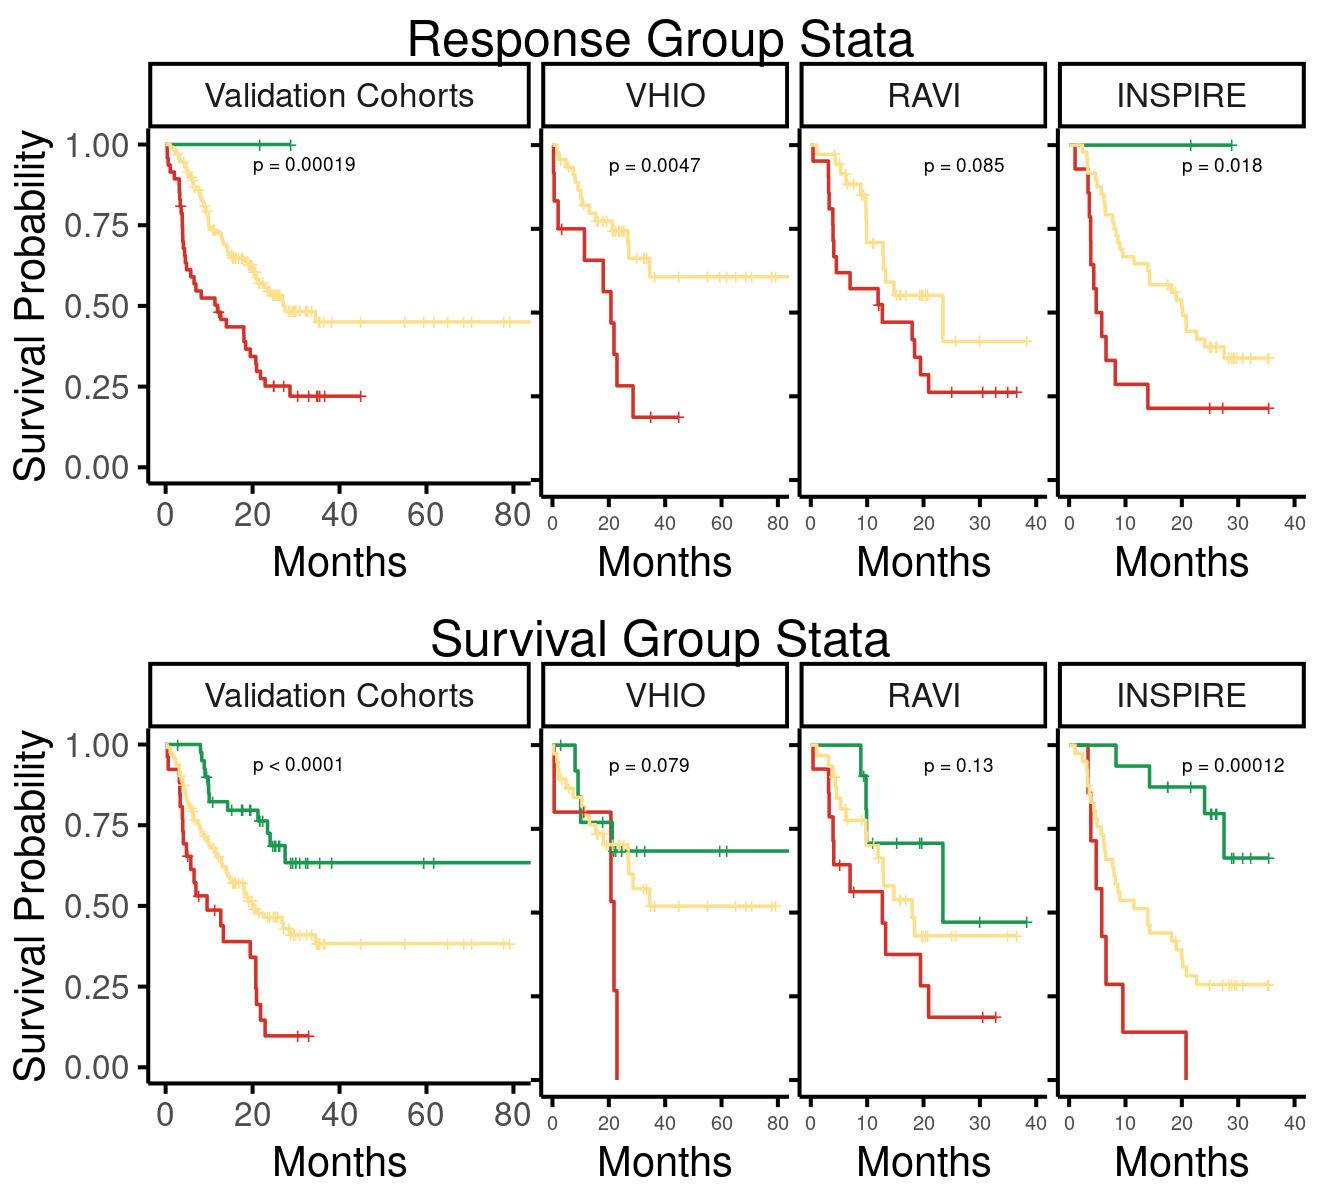

In [29]:
share

In [30]:
saveRDS( share, paste0(FIG_DIR, "6_sm_stratify_external_b.Rds"))